In [1]:
# import libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')

In [2]:
def partyswing(DemValue, RepValue):
    return (DemValue - RepValue) / (DemValue + RepValue) * 100

In [3]:
# bring in first data frame
df1 = pd.read_excel('20222020.xlsx')

In [4]:
df1.head()

,RaceName,SeqNo,Candidate,BallotOrder,DistrictNumber,DistrictName,County,Votes,ElectionYear
0,Turnout,0,Registered Voters,1,9,LEGISLATIVE DISTRICT 9,Adams,2680,2022
1,Turnout,0,Registered Voters,1,15,LEGISLATIVE DISTRICT 15,Adams,5183,2022
2,Turnout,0,Registered Voters,1,9,LEGISLATIVE DISTRICT 9,Asotin,14839,2022
3,Turnout,0,Registered Voters,1,8,LEGISLATIVE DISTRICT 8,Benton,70254,2022
4,Turnout,0,Registered Voters,1,15,LEGISLATIVE DISTRICT 15,Benton,1083,2022


In [5]:
# bring in second data frame
df2 = pd.read_excel('201420162018.xlsx')

In [6]:
df2.head()

,CountyCode,CountyName,DistrictTypeCode,DistrictCode,DistrictNumber,DistrictName,RaceJurisdictionTypeName,RaceJurisdictionName,RaceName,RaceDisplayOrder,BallotName,BallotDisplayOrder,votes,DistrictID,ElectionYear
0,AD,Adams,LEG,LEG9,9,Legislative District 9,Statewide,Statewide,Turnout,0,Registered Voters,0.5,6230,63414,2014
1,AD,Adams,LEG,LEG9,9,Legislative District 9,Statewide,Statewide,Turnout,0,Ballots Cast,0.8,3499,63414,2014
2,AD,Adams,LEG,LEG9,9,Legislative District 9,State Executive,State Measures,Init Meas No. 1351 Concerns K-12 education,1,Yes,1.0,1585,63414,2014
3,AD,Adams,LEG,LEG9,9,Legislative District 9,State Executive,State Measures,Init Meas No. 1351 Concerns K-12 education,1,No,2.0,1753,63414,2014
4,AD,Adams,LEG,LEG9,9,Legislative District 9,State Executive,State Measures,Init Meas No. 591 Concerns firearms,2,Yes,1.0,2003,63414,2014


In [7]:
# reordering and renaming columns
df3 = df1.reindex(columns=['ElectionYear', 'DistrictNumber', 'County', 'RaceName', 'Candidate', 'Votes'])
df3 = df3.rename(columns={'County': 'CountyName'})
df4 = df2.reindex(columns=['ElectionYear', 'DistrictNumber', 'CountyName', 'RaceName', 'BallotName', 'votes'])
df4 = df4.rename(columns={'votes': 'Votes', 'BallotName': 'Candidate'})

In [8]:
df3.head()

,ElectionYear,DistrictNumber,CountyName,RaceName,Candidate,Votes
0,2022,9,Adams,Turnout,Registered Voters,2680
1,2022,15,Adams,Turnout,Registered Voters,5183
2,2022,9,Asotin,Turnout,Registered Voters,14839
3,2022,8,Benton,Turnout,Registered Voters,70254
4,2022,15,Benton,Turnout,Registered Voters,1083


In [9]:
df4.head()

,ElectionYear,DistrictNumber,CountyName,RaceName,Candidate,Votes
0,2014,9,Adams,Turnout,Registered Voters,6230
1,2014,9,Adams,Turnout,Ballots Cast,3499
2,2014,9,Adams,Init Meas No. 1351 Concerns K-12 education,Yes,1585
3,2014,9,Adams,Init Meas No. 1351 Concerns K-12 education,No,1753
4,2014,9,Adams,Init Meas No. 591 Concerns firearms,Yes,2003


In [10]:
# combine them to one table with all 5 election cycles
df5 = pd.concat([df3, df4])
df5.head()

,ElectionYear,DistrictNumber,CountyName,RaceName,Candidate,Votes
0,2022,9,Adams,Turnout,Registered Voters,2680
1,2022,15,Adams,Turnout,Registered Voters,5183
2,2022,9,Asotin,Turnout,Registered Voters,14839
3,2022,8,Benton,Turnout,Registered Voters,70254
4,2022,15,Benton,Turnout,Registered Voters,1083


In [11]:
# initiate database
conn = sqlite3.connect('voter.db')

In [ ]:
# might delete this, haven't used
# c = conn.cursor()

In [12]:
# add in election data as table 'elections'
df5.to_sql('elections', conn, if_exists='replace')

15435

In [13]:
candidatesdf = pd.read_excel('CandidateParties.xlsx')
candidatesdf.to_sql('candidates', conn, if_exists='replace')

82

In [14]:
# Checks if any people are missing a political party label, should return an empty table
pd.read_sql("""
                SELECT elections.ElectionYear, elections.candidate, elections.Votes, candidates.PoliticalParty
                FROM elections 
                LEFT JOIN candidates ON elections.candidate=candidates.candidate
                WHERE candidates.PoliticalParty IS NULL 
                AND elections.candidate NOT LIKE "Registered Voters"
                AND elections.candidate NOT LIKE "Ballots Cast"
                AND elections.candidate NOT LIKE "Repealed"
                AND elections.candidate NOT LIKE "Maintained"
                AND elections.candidate NOT LIKE "WRITE-IN"
                AND elections.candidate NOT LIKE "Approved"
                AND elections.candidate NOT LIKE "Rejected"
                AND elections.candidate NOT LIKE "Yes"
                AND elections.candidate NOT LIKE "No"
                """, conn)

,ElectionYear,Candidate,Votes,PoliticalParty


In [15]:
# no partisan elections in 2014
pd.read_sql("""
                SELECT elections.ElectionYear, elections.DistrictNumber, elections.Votes, candidates.PoliticalParty
                FROM elections 
                LEFT JOIN candidates ON elections.candidate=candidates.candidate
                WHERE candidates.PoliticalParty = "Democratic Party"
                AND elections.ElectionYear = 2014
                """, conn)

,ElectionYear,DistrictNumber,Votes,PoliticalParty


In [27]:
# create table for party swing in elections
legdist_by_party = pd.read_sql("""
                SELECT elections.DistrictNumber, elections.ElectionYear, elections.Votes, candidates.PoliticalParty
                FROM elections 
                LEFT JOIN candidates ON elections.candidate=candidates.candidate
                WHERE candidates.PoliticalParty = "Republican Party"
                OR candidates.PoliticalParty = "Democratic Party"
                """, conn)

legdist_by_party_pivot = legdist_by_party.pivot_table(index=['DistrictNumber', 'ElectionYear' ,'PoliticalParty'], values=['Votes'], aggfunc='sum').reset_index()

legdist_by_party_results = pd.DataFrame(columns=['DistrictNumber', 'ElectionYear', 'Party Swing'])

for legdist in set(legdist_by_party_pivot['DistrictNumber']):
    results = legdist_by_party_pivot[legdist_by_party_pivot['DistrictNumber'] == legdist]
    
    for elecyear in set(results['ElectionYear']):
        results2 = results[results['ElectionYear'] == elecyear]
        swing = partyswing(float(results2[results2['PoliticalParty'] == "Democratic Party"]['Votes']), float(results2[results2['PoliticalParty'] == "Republican Party"]['Votes']))
        #pd.concat(legdist_by_party_results, pd.DataFrame([legdist, elecyear, swing]))
        legdist_by_party_results.loc[len(legdist_by_party_results.index)] = [str(legdist), elecyear, swing] 

legdist_by_party_results.head()
        

,DistrictNumber,ElectionYear,Party Swing
0,1,2016,27.911133
1,1,2018,28.538729
2,1,2020,42.362751
3,1,2022,73.917990
4,2,2016,-2.280609


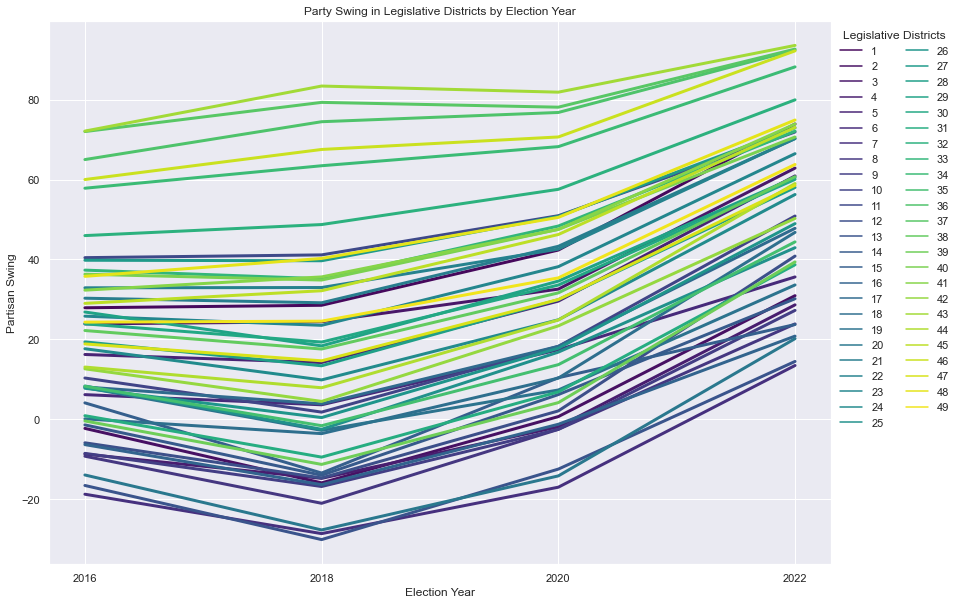

In [31]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(14,10)})

ax = sns.lineplot(data=legdist_by_party_results, x ='ElectionYear', y = 'Party Swing', hue='DistrictNumber',
                  palette='viridis', legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend(bbox_to_anchor=(1, 1), ncol=2, title="Legislative Districts")
plt.title('Party Swing in Legislative Districts by Election Year')
plt.ylabel('Partisan Swing')
plt.xlabel('Election Year')           
plt.show()
    

In [ ]:
import plotly.graph_objects as go

In [ ]:
#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(list(set(legdist_by_party_results['DistrictNumber'])))).as_hex())

fig = go.Figure()
for d,p in zip(legdist_by_party_results['DistrictNumber'], pal):
    fig.add_trace(go.Scatter(x = legdist_by_party_results['ElectionYear'],
                             y = legdist_by_party_results['Party Swing'],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

fig.show()



In [ ]:
pal[1]

In [ ]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(data1['DistrictNumber'], data1['Votes'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Courses offered")
plt.ylabel("No. of students enrolled")
plt.title("Students enrolled in different courses")
plt.show()

In [ ]:
pd.read_sql("""
                SELECT elections.DistrictNumber, elections.ElectionYear, elections.Votes,
                    SUM(CASE WHEN candidates.PoliticalParty = "Democratic Party" THEN elections.Votes ELSE 0 END) AS DemocraticVotes,
                    SUM(CASE WHEN candidates.PoliticalParty = "Republican Party" THEN elections.Votes ELSE 0 END) AS RepublicanVotes
                FROM elections 
                LEFT JOIN candidates ON elections.candidate=candidates.candidate
                GROUP BY elections.DistrictNumber, elections.ElectionYear
                """, conn)


In [ ]:
pd.read_sql("""
                SELECT elections.DistrictNumber, elections.ElectionYear, elections.Votes, candidates.PoliticalParty
                FROM elections 
                LEFT JOIN candidates ON elections.candidate=candidates.candidate
                WHERE elections.candidate = "Gary Johnson / Bill Weld"
                GROUP BY elections.DistrictNumber
                """, conn)

In [ ]:
pd.read_sql('SELECT count(candidate), PoliticalParty FROM candidates GROUP BY PoliticalParty', conn)

In [ ]:
leg5df = pd.read_sql("""SELECT SUM(CASE WHEN candidates.candidate = "Democratic Party" THEN elections.Votes ELSE 0 END)
                            AS DemocraticVotes,
                        SUM(CASE WHEN candidates.candidate = "Republican Party" THEN elections.Votes ELSE 0 END)
                            AS RepublicanVotes, elections.ElectionYear
                        FROM elections 
                        INNER JOIN candidates ON elections.candidate=candidates.candidate 
                        WHERE elections.DistrictNumber = 5 
                        GROUP BY elections.ElectionYear""", conn)
            

In [ ]:
leg5df = pd.read_sql("""SELECT elections.Votes, candidates.PoliticalParty, elections.ElectionYear
                        FROM elections 
                        INNER JOIN candidates ON elections.candidate=candidates.candidate 
                        WHERE elections.DistrictNumber = 5 
                        GROUP BY candidates.PoliticalParty, elections.ElectionYear""", conn)

In [ ]:
SELECT
    CASE
            WHEN view_count < 200  THEN '< 200'
            WHEN view_count < 500  THEN '< 500'
            WHEN view_count < 2000 THEN '< 2000'
            ...
            WHEN view_count < 1000000000 THEN '< 1B'
            ELSE 'More than 1B'
        END AS view_count_band,
        COUNT(*) AS pages_in_band
    FROM (
        SELECT page_title, COUNT(*) AS view_count
            FROM page_view
            WHERE year = YEAR()
            GROUP BY page_title
    ) AS yv
    GROUP BY visit_count
;

In [ ]:
leg5df

In [ ]:
plt.plot(leg5df.ElectionYear, leg5df.TotalVotes, 'o', color='black');

In [ ]:

plt.figure(figsize=(12, 8))
plt.scatter(legdist_by_party_results['ElectionYear'], legdist_by_party_results['Party Swing'],
            c = legdist_by_party_results['DistrictNumber'])
plt.plot(legdist_by_party_results['ElectionYear'], legdist_by_party_results['Party Swing'])
plt.title('Trends of Partisan Swing by Legislative District')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.ylabel('Partisan Swing')
plt.xlabel('Election Year')
plt.show()
